In [1]:
'''
sentiment file names for eng/ger
Merge labels and features depending on how labels are aggregated if there are multiple scores for a work.
drop_column reset index???
chunk based features?
complexity features
'''

'\nsentiment file names for eng/ger\nMerge labels and features depending on how labels are aggregated if there are multiple scores for a work.\ndrop_column reset index???\nchunk based features?\ncomplexity features\n'

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd

extracted_features_dir = "../data/extracted_features/"
results_dir = "../data/results/"
sentiment_dir = "../data/sentiment/"
canonization_labels_dir = "../data/labels/"
lang = "eng"

In [3]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
import xgboost
from xgboost import XGBRegressor
from copy import deepcopy
from scipy.stats import pearsonr
from utils import read_sentiment_scores
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
get_ipython().run_line_magic("matplotlib", "inline") # %matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import datetime
import random
random.seed(9)

labels = read_sentiment_scores(sentiment_dir, canonization_labels_dir)

<AxesSubplot:ylabel='Frequency'>

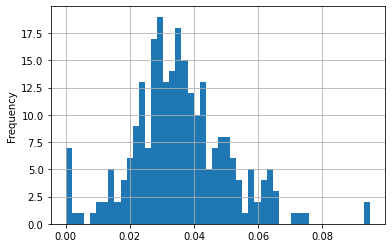

In [4]:
labels["y"].plot.hist(grid=True, bins=50)

In [5]:
class Experiment(object):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
        assert model in ["xgboost", "svr", "lasso", "ridge"]
        assert (dimensionality_reduction in ["k_best_f_reg_0_10", "k_best_mutual_info_0_10", "ss_pca_0_95"]) or (dimensionality_reduction is None)
        self.language = language
        self.features = features
        self.labels = labels
        self.drop_columns_including = drop_columns_including
        self.dimensionality_reduction = dimensionality_reduction
        self.model_param = model_param
        self.model = model
        self.verbose = verbose
        self.datetime = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

        if self.features == "book":
            self.df = deepcopy(book_df)
        elif self.features == "chunk":
            self.df = deepcopy(chunk_df)
        elif self.features == "chunk_and_copied_book":
            self.df = deepcopy(chunk_and_copied_book_df)
        elif self.features == "book_and_averaged_chunk":
            self.df = deepcopy(book_and_averaged_chunk_df)
        
        columns_before_drop = set(self.df.columns)
        self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
        
        print(list(self.df.columns))
    
    def _drop_column(self, column):
        for string in self.drop_columns_including:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X):
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction is None:
            pass
        return train_X, validation_X

    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    def _get_model(self, model_param, train_X=None, train_y=None, train_book_names=None):
        if self.model == "xgboost": #1,0.25,2
            def feval(preds, train_data):
                labels = train_data.get_label()
                return 'rmse', np.sqrt(mean_squared_error(labels, preds))
            dtrain = xgboost.DMatrix(train_X, label=train_y)
            results = []
            df = np.hstack((train_book_names, train_X))
            df = pd.DataFrame(df, columns=["book_name"] + [f"col_{i}" for i in range(train_X.shape[1])])
            for max_depth in [2, 4, 6, 8]:
                for learning_rate in [None, 0.01, 0.033, 0.1]:
                    for colsample_bytree in [0.33, 0.60, 0.75]:
                        params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1}
                        print("current_params:", params)
                        cv_results = xgboost.cv(
                                        params,
                                        dtrain,
                                        num_boost_round=99999,
                                        seed=42,
                                        nfold=5,
                                        folds=self._split_booknames(df, 5, return_indices=True),
                                        feval=feval,
                                        maximize=False,
                                        early_stopping_rounds=10,
                                        verbose_eval=False)
                        nested_cv_rmse = cv_results.iloc[len(cv_results)-1]["test-rmse-mean"]
                        num_boost_round = len(cv_results)
                        results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_rmse": nested_cv_rmse})
            best_parameters = sorted(results, key=lambda x: x["nested_cv_rmse"])[0]
            return best_parameters
        elif self.model == "svr":
            return SVR(C=model_param)
        elif self.model == "lasso":
            return Lasso(alpha=model_param)
        elif self.model == "ridge":
            return Ridge(alpha=model_param)

    def _split_booknames(self, df, nr_splits, return_indices=False):
        """
        Distribute book names over splits.
        All works of an author are in the same split.
        """
        book_names = df["book_name"].unique()
        authors = []
        booknames_authors_mapping = {}

        #Get authors
        for book_name in book_names:
            author = "_".join(book_name.split("_")[:2])
            authors.append(author)
            if author in booknames_authors_mapping:
                booknames_authors_mapping[author].append(book_name)
            else:
                booknames_authors_mapping[author] = []
                booknames_authors_mapping[author].append(book_name)
        #Distribute authors over splits so that each split has approximately the same number of books
        works_per_author = Counter(authors)
        goal_sum = round(len(book_names)/nr_splits)
        tolerance = 0.03
        lower_threshold = goal_sum - round(tolerance*goal_sum)
        upper_threshold = goal_sum + round(tolerance*goal_sum)
        author_splits = []
        popped_dict = {}

        for i in range (0, nr_splits-1):
            works_in_split = 0
            split = []
            curr_author_workcount = 0

            # take values from popped dict first
            if bool(popped_dict):
                popped = []
                for curr_author, curr_author_workcount in popped_dict.items():
                    # leave item in popped dict if value is too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        continue
                    else:
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                for current_author in popped:
                    del popped_dict[current_author]
            while works_in_split < upper_threshold:
                if bool(works_per_author):
                    curr_author = random.choice(list(works_per_author.keys()))
                    curr_author_workcount = works_per_author.pop(curr_author)
                    # Put values into separate dict if too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        popped_dict[curr_author] = curr_author_workcount
                    else:
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                else:
                    #ignore upper threshold
                    popped = []
                    for curr_author, curr_author_workcount in popped_dict.items():
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                    for current_author in popped:
                        del popped_dict[current_author]

            author_splits.append(split)
        #Create last split directly from remaining dict
        works_in_last_split = sum(works_per_author.values()) + sum(popped_dict.values())
        split = list(works_per_author.keys()) + list(popped_dict.keys())
        author_splits.append(split)

        if not return_indices:
            #Map author splits to book names
            book_splits = []
            for author_split in author_splits:
                book_split = []
                for author in author_split:
                    book_split.extend(booknames_authors_mapping[author])
                book_splits.append(book_split)
        else:
            book_name_idx_mapping = dict((book_name, index) for index, book_name in enumerate(book_names))
            book_splits = []
            for author_split in author_splits:
                test_split = []
                for author in author_split:
                    test_split.extend([book_name_idx_mapping[book_name] for book_name in booknames_authors_mapping[author]])
                train_split = list(set(book_name_idx_mapping.values()) - set(test_split))
                book_splits.append((train_split, test_split))
        return book_splits
    
    def _combine_df_labels(self, df):
        #Average of sentiscores per book
        agg_labels = labels.groupby(by="book_name", as_index=False).mean()
        df = df.merge(right=agg_labels, on="book_name", how="inner", validate="many_to_one")
        return df

    def _get_pvalue(self, validation_corr_pvalues):
        # Harmonic mean p-value
        denominator = sum([1/x for x in validation_corr_pvalues])
        mean_p_value = len(validation_corr_pvalues)/denominator
        return mean_p_value
    
    def run(self):
        all_predictions = []
        all_labels = []

        train_mses = []
        train_maes = []
        train_r2s = []
        train_corrs = []
        
        validation_mses = []
        validation_maes = []
        validation_r2s = []
        validation_corrs = []
        validation_corr_pvalues = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 10, return_indices=False)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            
            # train_X, validation_X = self._scale(train_X, validation_X)
            
            train_X, validation_X = self._impute(train_X, validation_X)
            
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names)
                dtrain = xgboost.DMatrix(train_X, label=train_y)
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_rmse")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)

            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            all_validation_books.append(validation_books.reset_index())
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            train_r2 = r2_score(train_y, train_yhat)
            train_corr = pearsonr(train_y, train_yhat)[0]
            
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            validation_corr = pearsonr(validation_y, validation_yhat)[0]
            p_value = pearsonr(validation_y, validation_yhat)[1]
            
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            train_r2s.append(train_r2)
            train_corrs.append(train_corr)
            
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            validation_corrs.append(validation_corr)
            validation_corr_pvalues.append(p_value)
            
            if self.verbose:
                print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 5)}, TrainMAE: {np.round(train_mae, 5)}, ValMSE: {np.round(validation_mse, 5)}, ValMAE: {np.round(validation_mae, 5)}, ValR2: {np.round(validation_r2, 5)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        
        # Save y and y_pred for examples
        mean_train_mse = np.mean(train_mses)
        mean_train_rmse = np.mean([sqrt(x) for x in train_mses])
        mean_train_mae = np.mean(train_maes)
        mean_train_r2 = np.mean(train_r2s)
        mean_train_corr = np.mean(train_corrs)
        
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        mean_validation_corr = np.mean(validation_corrs)
        mean_p_value = self._get_pvalue(validation_corr_pvalues)
        
        if self.verbose:
            print(f"""Means: TrainMSE: {np.round(mean_train_mse, 5)}, TrainRMSE: {np.round(mean_train_rmse, 5)}, TrainMAE: {np.round(mean_train_mae, 5)}, TrainR2: {np.round(mean_train_r2, 5)}, TrainCorr: {np.round(mean_train_corr, 5)}, ValMSE: {np.round(mean_validation_mse, 5)}, ValRMSE: {np.round(mean_validation_rmse, 5)}, ValMAE: {np.round(mean_validation_mae, 5)}, ValR2: {np.round(mean_validation_r2, 5)}, ValCorr: {np.round(mean_validation_corr, 5)}, ValCorrPValue: {np.round(mean_p_value, 5)}""")
            print("------")
            plt.figure(figsize=(4,4))
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            # plt.xlim([0,0.2])
            # plt.ylim([0,0.2])

            plt.scatter(all_labels, all_predictions, s=6)
            plt.xlabel("Evaluation Scores", fontsize=20)
            plt.ylabel("Predicted Scores", fontsize=20)
            plt.savefig(results_dir + lang + "-" + self.model + "-" + str(self.dimensionality_reduction) + "-dropped_columns_including_" + str("_".join(self.drop_columns_including))
            + "-" + self.features + "-" + "-" + "param" + str(self.model_param) + "-" + self.datetime + ".png", 
            dpi=400, bbox_inches="tight")

            plt.show();
        return mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value, self.datetime


In [6]:
# Drop some columns by default before running cv
# def drop_default_columns(df, drop_default_columns_including):
#     def _drop_column(column):
#         for string in drop_default_columns_including:
#             if string in column:
#                 return True
#     df = df[[column for column in df.columns if not _drop_column(column)]].reset_index(drop=True)
#     return df

### Cross-validation

# Superflous features
# drop_default_columns_including = ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"] #, "->", "pos"]

# All parameters
# models = ["svr", "lasso", "ridge", "xgboost"]
# model_params = {"svr": [1], "lasso": [1e-15, 1e-12, 1e-9], "ridge": [1e-12, 1e-9, 1e-6], "xgboost": [1, 4]}
# dimensionality_reduction = ["ss_pca_0_95", 'k_best_f_reg_0_10', 'k_best_mutual_info_0_10', None]
# features = ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]

# # Which parameters to use
# full_cv_params = {"model": models, "dimensionality_reduction": dimensionality_reduction, "features": features}
# testing_params = {"model": models[1], "dimensionality_reduction": dimensionality_reduction[-1], 
#                   "features": features[3]} # svr, k_best_f_reg_0_10, book_and_averaged_chunk
# # Old results from chr2021 paper
# eng_params = {"model": models[0], "dimensionality_reduction": dimensionality_reduction[0], 
#                   "features": features[3], }, # svr, pca, book_and_average_chunk
# ger_params = {"model": models[0], "dimensionality_reduction": dimensionality_reduction[0], 
#               "features": features[1]}, # svr, pca, chunk


In [7]:
# results = []
# param_dict = "testing" #"full_cv", "language_specific"
# for lang in ["eng"]: #, "ger"]:
#     if param_dict=="testing":
#         param_dir = testing_params
#     elif param_dict=="full_cv":
#         param_dir = full_cv_params
#     elif param_dict=="language_specific":
#         if lang=="eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params

#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
#     book_df = drop_default_columns(book_df, drop_default_columns_including)
#     book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
#     chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
#     chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)

#     for model in [param_dir['model']]:
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in [param_dir["dimensionality_reduction"]]:
#                 for features in [param_dir["features"]]:
#                     #try:
#                     experiment = Experiment(
#                         language=lang,
#                         features=features,
#                         dimensionality_reduction=dimensionality_reduction,
#                         model_param=model_param,
#                         model=model,
#                         verbose=True
#                     )
#                     print(lang, model, features, dimensionality_reduction, model_param)
#                     mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value, dt = experiment.run()
#                     results.append((lang, model, features, dimensionality_reduction, model_param, mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value))

                    #except Exception as e:
#                             print(f"Error in {lang}, {model}, {features}, {drop_columns_including}, {dimensionality_reduction}")
#                             print(e)

In [8]:
# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
#             "dimensionality_reduction", "model_param", "mean_train_mse", "mean_train_rmse", 
#             "mean_train_mae", "mean_train_r2", "mean_train_corr", "mean_validation_mse", "mean_validation_rmse",
#             "mean_validation_mae", "mean_validation_r2", "mean_validation_corr", "mean_p_value"])
# results_df.to_csv(results_dir + param_dict + datetime + ".csv", index=False)

Dropped 300 columns.
['book_name', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'pos_unigram_PUNCT', 'pos_unigram_NOUN', 'pos_unigram_VERB', 'pos_unigram_PRON', 'pos_unigram_ADP', 'pos_unigram_DET', 'pos_unigram_ADJ', 'pos_unigram_ADV', 'pos_unigram_AUX', 'pos_unigram_PROPN', 'pos_unigram_CCONJ', 'pos_unigram_PART', 'pos_unigram_SCONJ', 'pos_unigram_NUM', 'pos_unigram_INTJ', 'pos_unigram_X', 'pos_unigram_SPACE', 'pos_unigram_SYM', 'pos_bigram_NOUN_PUNCT', 'pos_bigram_DET_NOUN', 'pos_bigram_PUNCT_EOS', 'pos_bigram_ADP_DET', 'pos_bigram_NOUN_ADP', 'pos_bigram_ADJ_NOUN', 'pos_bigram_PRON_VERB', 'pos_bigram_VERB_PRON', 'pos_bigram_VERB_ADP', 'pos_bigram_ADP_PRON', 'pos_bigram_PRON_AUX', 'pos_bigram_AUX_VERB', 'pos_bigram_PUNCT_CCONJ', 'pos_bigram_PRON_NOUN', 'pos_bigram_PUNCT_PUNCT', 'pos_bigram_DET

current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_r

current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 3, TrainMSE: 3e-05, TrainMAE: 0.00396, ValMSE: 0.00013, ValMAE: 0.0076, ValR2: 0.22745
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_ra

current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learnin

current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learnin

current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learnin

Fold: 10, TrainMSE: 0.0, TrainMAE: 0.00033, ValMSE: 0.00024, ValMAE: 0.01215, ValR2: -0.0358
Means: TrainMSE: 0.0, TrainRMSE: 0.00097, TrainMAE: 0.00071, TrainR2: 0.98067, TrainCorr: 0.99209, ValMSE: 0.00013, ValRMSE: 0.01126, ValMAE: 0.00866, ValR2: 0.10627, ValCorr: 0.46268, ValCorrPValue: 0.00124
------


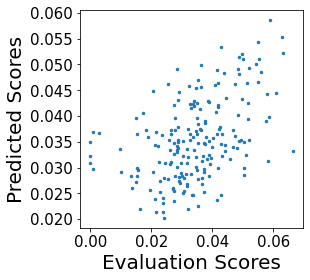

Dropped 868 columns.
['book_name', 'ratio_of_punctuation_marks', 'ratio_of_whitespaces', 'ratio_of_digits', 'ratio_of_exclamation_marks', 'ratio_of_question_marks', 'ratio_of_commas', 'ratio_of_uppercase_letters', 'average_number_of_words_in_sentence', 'maximum_number_of_words_in_sentence', 'ratio_of_unique_word_unigrams', 'ratio_of_unique_word_bigrams', 'ratio_of_unique_word_trigrams', 'text_length', 'average_word_length', 'ratio_of_stopwords', 'bigram_entropy', 'trigram_entropy', 'type_token_ratio', 'flesch_reading_ease_score', 'unigram_entropy', 'average_paragraph_length']
eng xgboost chunk None None
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
curren

current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_ra

current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_ra

current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_ra

current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 7, TrainMSE: 5e-05, TrainMAE: 0.00525, ValMSE: 7e-05, ValMAE: 0.00693, ValR2: 0.32397
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate':

current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_ra

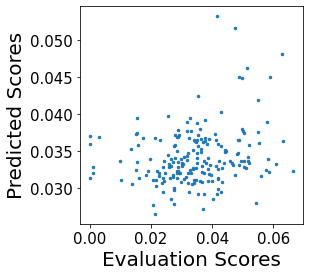

Dropped 1168 columns.
['book_name', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'pos_unigram_PUNCT', 'pos_unigram_NOUN', 'pos_unigram_VERB', 'pos_unigram_PRON', 'pos_unigram_ADP', 'pos_unigram_DET', 'pos_unigram_ADJ', 'pos_unigram_ADV', 'pos_unigram_AUX', 'pos_unigram_PROPN', 'pos_unigram_CCONJ', 'pos_unigram_PART', 'pos_unigram_SCONJ', 'pos_unigram_NUM', 'pos_unigram_INTJ', 'pos_unigram_X', 'pos_unigram_SPACE', 'pos_unigram_SYM', 'pos_bigram_NOUN_PUNCT', 'pos_bigram_DET_NOUN', 'pos_bigram_PUNCT_EOS', 'pos_bigram_ADP_DET', 'pos_bigram_NOUN_ADP', 'pos_bigram_ADJ_NOUN', 'pos_bigram_PRON_VERB', 'pos_bigram_VERB_PRON', 'pos_bigram_VERB_ADP', 'pos_bigram_ADP_PRON', 'pos_bigram_PRON_AUX', 'pos_bigram_AUX_VERB', 'pos_bigram_PUNCT_CCONJ', 'pos_bigram_PRON_NOUN', 'pos_bigram_PUNCT_PUNCT', 'pos_bigram_DE

current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_r

current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 3, TrainMSE: 0.0, TrainMAE: 0.00031, ValMSE: 9e-05, ValMAE: 0.00802, ValR2: -0.06791
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate'

current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_

current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_

current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_

current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 10, TrainMSE: 0.0, TrainMAE: 0.00032, ValMSE: 0.00014, ValMAE: 0.00954, ValR2: -0.04825
Means: TrainMSE: 0.0, TrainRMSE: 0.00045, TrainMAE: 0.00031, TrainR2: 0.99878, TrainCorr: 0.99969, ValMSE: 0.00013, ValRMSE: 0.01149, ValMAE: 0.00902, ValR2: 0.03438, ValCorr: 0.50356, ValCorrPValue: 0.00159
------


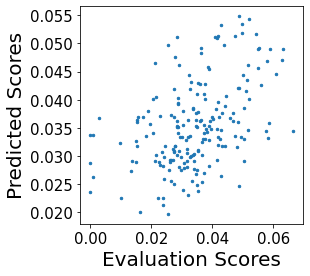

Dropped 1168 columns.
['book_name', 'ratio_of_punctuation_marks', 'ratio_of_whitespaces', 'ratio_of_digits', 'ratio_of_exclamation_marks', 'ratio_of_question_marks', 'ratio_of_commas', 'ratio_of_uppercase_letters', 'average_number_of_words_in_sentence', 'maximum_number_of_words_in_sentence', 'ratio_of_unique_word_unigrams', 'ratio_of_unique_word_bigrams', 'ratio_of_unique_word_trigrams', 'text_length', 'average_word_length', 'ratio_of_stopwords', 'bigram_entropy', 'trigram_entropy', 'type_token_ratio', 'flesch_reading_ease_score', 'unigram_entropy', 'average_paragraph_length', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'pos_unigram_PUNCT', 'pos_unigram_NOUN', 'pos_unigram_VERB', 'pos_unigram_PRON', 'pos_unigram_ADP', 'pos_unigram_DET', 'pos_unigram_ADJ', 'pos_unigram_ADV', 'pos_unigram_AUX', '

current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_r

current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 3, TrainMSE: 0.0, TrainMAE: 8e-05, ValMSE: 0.00018, ValMAE: 0.01122, ValR2: -0.12548
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate'

current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_

current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_

current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_

current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 10, TrainMSE: 0.0, TrainMAE: 9e-05, ValMSE: 0.00011, ValMAE: 0.00837, ValR2: 0.34411
Means: TrainMSE: 1e-05, TrainRMSE: 0.00134, TrainMAE: 0.00095, TrainR2: 0.96846, TrainCorr: 0.98661, ValMSE: 0.00014, ValRMSE: 0.01169, ValMAE: 0.00937, ValR2: 0.02473, ValCorr: 0.4339, ValCorrPValue: 0.00622
------


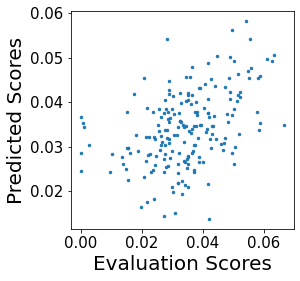

Dropped 330 columns.
['book_name', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'pos_unigram_PUNCT', 'pos_unigram_NOUN', 'pos_unigram_VERB', 'pos_unigram_PRON', 'pos_unigram_ADP', 'pos_unigram_DET', 'pos_unigram_ADJ', 'pos_unigram_ADV', 'pos_unigram_AUX', 'pos_unigram_PROPN', 'pos_unigram_CCONJ', 'pos_unigram_PART', 'pos_unigram_SCONJ', 'pos_unigram_NUM', 'pos_unigram_INTJ', 'pos_unigram_X', 'pos_unigram_SPACE', 'pos_unigram_SYM', 'pos_bigram_NOUN_PUNCT', 'pos_bigram_DET_NOUN', 'pos_bigram_PUNCT_EOS', 'pos_bigram_ADP_DET', 'pos_bigram_NOUN_ADP', 'pos_bigram_ADJ_NOUN', 'pos_bigram_PRON_VERB', 'pos_bigram_VERB_PRON', 'pos_bigram_VERB_ADP', 'pos_bigram_ADP_PRON', 'pos_bigram_PRON_AUX', 'pos_bigram_AUX_VERB', 'pos_bigram_PUNCT_CCONJ', 'pos_bigram_PRON_NOUN', 'pos_bigram_PUNCT_PUNCT', 'pos_bigram_DET

current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_

current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_

current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 5, TrainMSE: 0.0, TrainMAE: 0.00032, ValMSE: 0.00024, ValMAE: 0.01111, ValR2: -0.5231
current_params: {'max_depth': 2, 'learning_rate

current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_

current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_

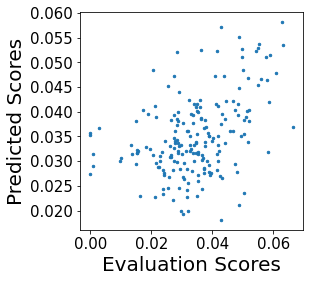

Dropped 868 columns.
['book_name', 'ratio_of_punctuation_marks', 'ratio_of_whitespaces', 'ratio_of_digits', 'ratio_of_exclamation_marks', 'ratio_of_question_marks', 'ratio_of_commas', 'ratio_of_uppercase_letters', 'average_number_of_words_in_sentence', 'maximum_number_of_words_in_sentence', 'ratio_of_unique_word_unigrams', 'ratio_of_unique_word_bigrams', 'ratio_of_unique_word_trigrams', 'text_length', 'average_word_length', 'ratio_of_stopwords', 'bigram_entropy', 'trigram_entropy', 'type_token_ratio', 'flesch_reading_ease_score', 'unigram_entropy', 'average_paragraph_length']
eng xgboost chunk None None
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
curren

current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_ra

current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_ra

current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_ra

current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 7, TrainMSE: 0.0001, TrainMAE: 0.0079, ValMSE: 0.0002, ValMAE: 0.00938, ValR2: 0.12068
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate'

current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_ra

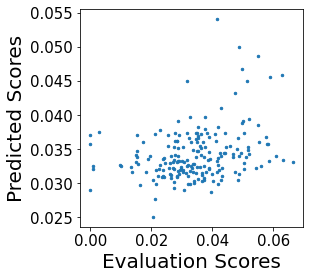

Dropped 1198 columns.
['book_name', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'pos_unigram_PUNCT', 'pos_unigram_NOUN', 'pos_unigram_VERB', 'pos_unigram_PRON', 'pos_unigram_ADP', 'pos_unigram_DET', 'pos_unigram_ADJ', 'pos_unigram_ADV', 'pos_unigram_AUX', 'pos_unigram_PROPN', 'pos_unigram_CCONJ', 'pos_unigram_PART', 'pos_unigram_SCONJ', 'pos_unigram_NUM', 'pos_unigram_INTJ', 'pos_unigram_X', 'pos_unigram_SPACE', 'pos_unigram_SYM', 'pos_bigram_NOUN_PUNCT', 'pos_bigram_DET_NOUN', 'pos_bigram_PUNCT_EOS', 'pos_bigram_ADP_DET', 'pos_bigram_NOUN_ADP', 'pos_bigram_ADJ_NOUN', 'pos_bigram_PRON_VERB', 'pos_bigram_VERB_PRON', 'pos_bigram_VERB_ADP', 'pos_bigram_ADP_PRON', 'pos_bigram_PRON_AUX', 'pos_bigram_AUX_VERB', 'pos_bigram_PUNCT_CCONJ', 'pos_bigram_PRON_NOUN', 'pos_bigram_PUNCT_PUNCT', 'pos_bigram_DE

current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_ra

current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 3, TrainMSE: 0.0, TrainMAE: 0.00034, ValMSE: 0.00012, ValMAE: 0.00832, ValR2: 0.39677
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 

current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_ra

current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_ra

current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_ra

current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 10, TrainMSE: 0.0, TrainMAE: 0.00036, ValMSE: 0.00015, ValMAE: 0.00955, ValR2: 0.00476
Means: TrainMSE: 0.0, TrainRMSE: 0.00048, TrainMAE: 0.00034, TrainR2: 0.99859, TrainCorr: 0.99965, ValMSE: 0.00015, ValRMSE: 0.01207, ValMAE: 0.00944, ValR2: -0.06568, ValCorr: 0.3722, ValCorrPValue: 0.02325
------


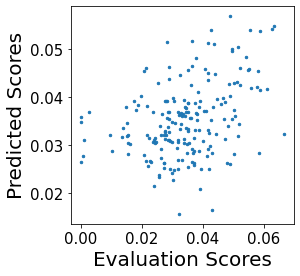

Dropped 1198 columns.
['book_name', 'ratio_of_punctuation_marks', 'ratio_of_whitespaces', 'ratio_of_digits', 'ratio_of_exclamation_marks', 'ratio_of_question_marks', 'ratio_of_commas', 'ratio_of_uppercase_letters', 'average_number_of_words_in_sentence', 'maximum_number_of_words_in_sentence', 'ratio_of_unique_word_unigrams', 'ratio_of_unique_word_bigrams', 'ratio_of_unique_word_trigrams', 'text_length', 'average_word_length', 'ratio_of_stopwords', 'bigram_entropy', 'trigram_entropy', 'type_token_ratio', 'flesch_reading_ease_score', 'unigram_entropy', 'average_paragraph_length', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'pos_unigram_PUNCT', 'pos_unigram_NOUN', 'pos_unigram_VERB', 'pos_unigram_PRON', 'pos_unigram_ADP', 'pos_unigram_DET', 'pos_unigram_ADJ', 'pos_unigram_ADV', 'pos_unigram_AUX', '

current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_ra

current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 3, TrainMSE: 0.0, TrainMAE: 8e-05, ValMSE: 0.00012, ValMAE: 0.00803, ValR2: 0.35623
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.

current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_ra

current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_ra

current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_ra

current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 10, TrainMSE: 0.0, TrainMAE: 9e-05, ValMSE: 0.00022, ValMAE: 0.01217, ValR2: -0.22624
Means: TrainMSE: 0.0, TrainRMSE: 0.00074, TrainMAE: 0.00052, TrainR2: 0.98601, TrainCorr: 0.9942, ValMSE: 0.00014, ValRMSE: 0.01174, ValMAE: 0.00909, ValR2: -0.07101, ValCorr: 0.40647, ValCorrPValue: 0.02064
------


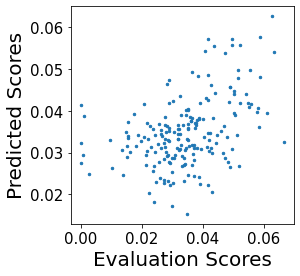

Dropped 378 columns.
['book_name', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'error_rate', 'PP->IN', 'NP->PRP', 'NP->DT_NN', 'VP->VBD', 'NP->NN', 'NP->PRP$_NN', 'NP->JJ', 'VP->VBP', 'NP->DT_JJ_NN', 'NP->NNP', 'VP->TO_VB', 'VP->VBZ', 'NP->JJ_NN', 'VP->VB', 'VP->MD_VB', 'VP->VBG', 'NP->NNS', 'NP->NNP_NNP', 'VP->VBD_VBN', 'VP->TO', 'NP->WDT', 'VP->VBD_RB', 'NP->DT_NNS', 'NP->WP', 'NP->DT_NN_NN', 'NP->DT', 'NP->PRP$_JJ_NN', 'NP->NN_NN', 'VP->VBN', 'NP->DT_NNP']
eng xgboost book None None
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth

current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_

current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_

current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_

current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 7, TrainMSE: 0.0, TrainMAE: 0.00035, ValMSE: 8e-05, ValMAE: 0.00728, ValR2: 0.10514
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 

current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_ra

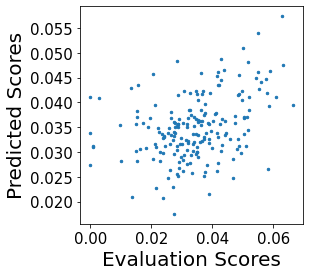

Dropped 868 columns.
['book_name', 'ratio_of_punctuation_marks', 'ratio_of_whitespaces', 'ratio_of_digits', 'ratio_of_exclamation_marks', 'ratio_of_question_marks', 'ratio_of_commas', 'ratio_of_uppercase_letters', 'average_number_of_words_in_sentence', 'maximum_number_of_words_in_sentence', 'ratio_of_unique_word_unigrams', 'ratio_of_unique_word_bigrams', 'ratio_of_unique_word_trigrams', 'text_length', 'average_word_length', 'ratio_of_stopwords', 'bigram_entropy', 'trigram_entropy', 'type_token_ratio', 'flesch_reading_ease_score', 'unigram_entropy', 'average_paragraph_length']
eng xgboost chunk None None
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
curren

current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_ra

current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_ra

current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_ra

current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 7, TrainMSE: 5e-05, TrainMAE: 0.00506, ValMSE: 0.00012, ValMAE: 0.0086, ValR2: 0.01176
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate'

current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_ra

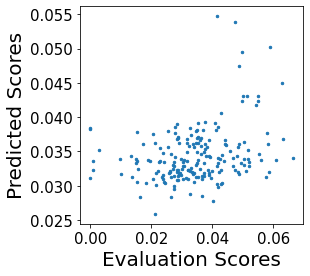

Dropped 1246 columns.
['book_name', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'error_rate', 'PP->IN', 'NP->PRP', 'NP->DT_NN', 'VP->VBD', 'NP->NN', 'NP->PRP$_NN', 'NP->JJ', 'VP->VBP', 'NP->DT_JJ_NN', 'NP->NNP', 'VP->TO_VB', 'VP->VBZ', 'NP->JJ_NN', 'VP->VB', 'VP->MD_VB', 'VP->VBG', 'NP->NNS', 'NP->NNP_NNP', 'VP->VBD_VBN', 'VP->TO', 'NP->WDT', 'VP->VBD_RB', 'NP->DT_NNS', 'NP->WP', 'NP->DT_NN_NN', 'NP->DT', 'NP->PRP$_JJ_NN', 'NP->NN_NN', 'VP->VBN', 'NP->DT_NNP', 'ratio_of_punctuation_marks', 'ratio_of_whitespaces', 'ratio_of_digits', 'ratio_of_exclamation_marks', 'ratio_of_question_marks', 'ratio_of_commas', 'ratio_of_uppercase_letters', 'average_number_of_words_in_sentence', 'maximum_number_of_words_in_sentence', 'ratio_of_unique_word_unigrams', 'ratio_of_unique_word_bigrams', 'ratio_of_unique_w

current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learnin

current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learnin

current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_

current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 7, TrainMSE: 0.0, TrainMAE: 0.00034, ValMSE: 0.0002, ValMAE: 0.01084, ValR2: 0.10124
current_params: {'max_depth': 2, 'learning_rate'

current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_

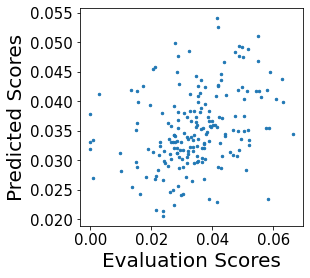

Dropped 1246 columns.
['book_name', 'ratio_of_punctuation_marks', 'ratio_of_whitespaces', 'ratio_of_digits', 'ratio_of_exclamation_marks', 'ratio_of_question_marks', 'ratio_of_commas', 'ratio_of_uppercase_letters', 'average_number_of_words_in_sentence', 'maximum_number_of_words_in_sentence', 'ratio_of_unique_word_unigrams', 'ratio_of_unique_word_bigrams', 'ratio_of_unique_word_trigrams', 'text_length', 'average_word_length', 'ratio_of_stopwords', 'bigram_entropy', 'trigram_entropy', 'type_token_ratio', 'flesch_reading_ease_score', 'unigram_entropy', 'average_paragraph_length', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'error_rate', 'PP->IN', 'NP->PRP', 'NP->DT_NN', 'VP->VBD', 'NP->NN', 'NP->PRP$_NN', 'NP->JJ', 'VP->VBP', 'NP->DT_JJ_NN', 'NP->NNP', 'VP->TO_VB', 'VP->VBZ', 'NP->JJ_NN', 'VP->VB'

current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learnin

current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learnin

current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_

current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 7, TrainMSE: 0.0, TrainMAE: 0.00071, 

current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_

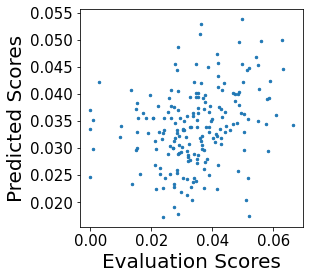

Dropped 408 columns.
['book_name', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'error_rate']
eng xgboost book None None
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params

current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_r

current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_r

current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_r

current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 7, TrainMSE: 0.0, TrainMAE: 0.0008, ValMSE: 9e-05, ValMAE: 0.00685, ValR2: -0.04332
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate'

current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learnin

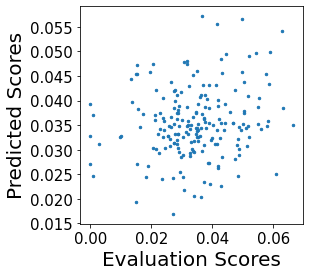

Dropped 868 columns.
['book_name', 'ratio_of_punctuation_marks', 'ratio_of_whitespaces', 'ratio_of_digits', 'ratio_of_exclamation_marks', 'ratio_of_question_marks', 'ratio_of_commas', 'ratio_of_uppercase_letters', 'average_number_of_words_in_sentence', 'maximum_number_of_words_in_sentence', 'ratio_of_unique_word_unigrams', 'ratio_of_unique_word_bigrams', 'ratio_of_unique_word_trigrams', 'text_length', 'average_word_length', 'ratio_of_stopwords', 'bigram_entropy', 'trigram_entropy', 'type_token_ratio', 'flesch_reading_ease_score', 'unigram_entropy', 'average_paragraph_length']
eng xgboost chunk None None
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
curren

current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_ra

current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_ra

current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_ra

current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 7, TrainMSE: 0.0001, TrainMAE: 0.00752, ValMSE: 0.0002, ValMAE: 0.01168, ValR2: -0.04035
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rat

current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_ra

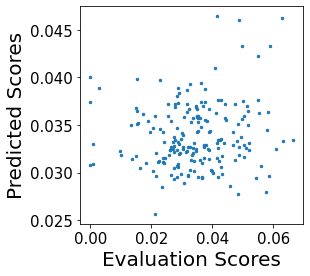

Dropped 1276 columns.
['book_name', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'error_rate', 'ratio_of_punctuation_marks', 'ratio_of_whitespaces', 'ratio_of_digits', 'ratio_of_exclamation_marks', 'ratio_of_question_marks', 'ratio_of_commas', 'ratio_of_uppercase_letters', 'average_number_of_words_in_sentence', 'maximum_number_of_words_in_sentence', 'ratio_of_unique_word_unigrams', 'ratio_of_unique_word_bigrams', 'ratio_of_unique_word_trigrams', 'text_length', 'average_word_length', 'ratio_of_stopwords', 'bigram_entropy', 'trigram_entropy', 'type_token_ratio', 'flesch_reading_ease_score', 'unigram_entropy', 'average_paragraph_length']
eng xgboost book_and_averaged_chunk None None
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max

current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_r

current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_r

current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_r

current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 7, TrainMSE: 0.0, TrainMAE: 0.00042, ValMSE: 0.00011, ValMAE: 0.00827, ValR2: -0.24247
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rat

current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_

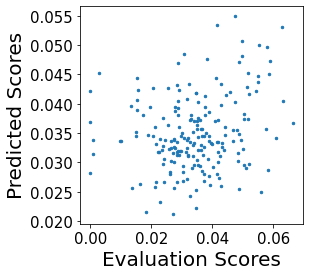

Dropped 1276 columns.
['book_name', 'ratio_of_punctuation_marks', 'ratio_of_whitespaces', 'ratio_of_digits', 'ratio_of_exclamation_marks', 'ratio_of_question_marks', 'ratio_of_commas', 'ratio_of_uppercase_letters', 'average_number_of_words_in_sentence', 'maximum_number_of_words_in_sentence', 'ratio_of_unique_word_unigrams', 'ratio_of_unique_word_bigrams', 'ratio_of_unique_word_trigrams', 'text_length', 'average_word_length', 'ratio_of_stopwords', 'bigram_entropy', 'trigram_entropy', 'type_token_ratio', 'flesch_reading_ease_score', 'unigram_entropy', 'average_paragraph_length', 'doc2vec_intra_textual_variance', 'sbert_intra_textual_variance', 'doc2vec_stepwise_distance', 'sbert_stepwise_distance', 'overlap_score_doc2vec', 'overlap_score_sbert', 'outlier_score_doc2vec', 'outlier_score_sbert', 'wordfreq_distance', 'error_rate']
eng xgboost chunk_and_copied_book None None
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_d

current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_r

current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_r

current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 4, 'learning_r

current_params: {'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
Fold: 7, TrainMSE: 6e-05, TrainMAE: 0.00569, ValMSE: 0.00014, ValMAE: 0.00991, ValR2: -0.73066
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 2, 'learning_r

current_params: {'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.033, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.33, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.6, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_rate': None, 'colsample_bytree': 0.75, 'n_jobs': -1}
current_params: {'max_depth': 8, 'learning_

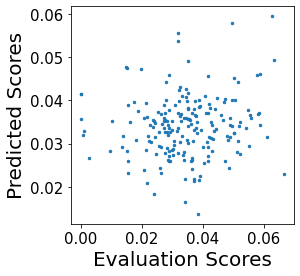

In [9]:
results = []
# param_dict = "testing" #"full_cv", "language_specific"
for lang in ["eng"]: #, "ger"]:    
#     if param_dict=="testing":
#         param_dir = testing_params
#     elif param_dict=="full_cv":
#         param_dir = full_cv_params
#     elif param_dict=="language_specific":
#         if lang=="eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params

    book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
#     book_df = drop_default_columns(book_df, drop_default_columns_including)
#     book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
#     chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
#     chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)

    for model in ["xgboost"]:
        for model_param in [None]:
            for dimensionality_reduction in [None]:
                for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
                                               ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
                                               ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
                                               ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
                    for features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]:
                        experiment = Experiment(
                            language=lang,
                            features=features,
                            drop_columns_including=drop_columns_including,
                            dimensionality_reduction=dimensionality_reduction,
                            model_param=model_param,
                            model=model,
                            verbose=True
                        )
                        print(lang, model, features, dimensionality_reduction, model_param)
                        mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value, dt = experiment.run()
                        results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value))

                        #except Exception as e:
    #                             print(f"Error in {lang}, {model}, {features}, {drop_columns_including}, {dimensionality_reduction}")
    #                             print(e)

In [10]:
results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", "dimensionality_reduction", "model_param", "mean_train_mse", "mean_train_rmse", "mean_train_mae", "mean_train_r2", "mean_train_corr", "mean_validation_mse", "mean_validation_rmse", "mean_validation_mae", "mean_validation_r2", "mean_validation_corr", "mean_p_value"])
results_df.to_csv("../data/results/2021_12_07_xgboost_nested_cv_results.csv", index=False)
